In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm

In [2]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = False
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

In [3]:
directory = "/hpcwork/zu992399/look_elsewhere/NN_test/NN_test_kfoldscorrected/"
generate_data = True

# Generate Data

In [4]:
def p_value_poissonpoisson_2tailed(N_data, N_BT, k=0.5):
    p_value = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    p_left = stats.nbinom.cdf(N_data, N_BT, 0.5)
    return np.min(np.array([p_value, p_left]), axis=0)*2

def p_value_poissonpoisson(N_data, N_BT, k=0.5):
    return 1-stats.nbinom.cdf(N_data-1, N_BT, k)

def p_values_from_folder(load_folder, save_folder, save_file, remove_0s=True, twotailed=False):
    N_samples_after = np.load(load_folder+"N_samples_after.npy")
    N_samples = np.load(load_folder+"N_samples.npy")
    N_after = np.load(load_folder+"N_after.npy")
    N = np.load(load_folder+"N.npy")
    p = []
    for i in range(len(N[0])):
        if twotailed:
            if remove_0s:
                inds = np.nonzero(N_samples_after[:,i])[0]
                inds2 = np.nonzero(N_after[inds,i])[0]
                p.append(np.sort(p_value_poissonpoisson_2tailed(N_after[inds,i][inds2], N_samples_after[inds,i][inds2]/N_samples[inds,i][inds2]*N[inds,i][inds2])))
            else: 
                p.append(np.sort(p_value_poissonpoisson_2tailed(N_after[:,i], N_samples_after[:,i]/N_samples[:,i]*N[:,i])))
        else:
            if remove_0s:
                inds = np.nonzero(N_samples_after[:,i])[0]
                inds2 = np.nonzero(N_after[inds,i])[0]
                p.append(np.sort(p_value_poissonpoisson(N_after[inds,i][inds2], N_samples_after[inds,i][inds2]/N_samples[inds,i][inds2]*N[inds,i][inds2])))
            else: 
                p.append(np.sort(p_value_poissonpoisson(N_after[:,i], N_samples_after[:,i]/N_samples[:,i]*N[:,i])))
    np.save(save_folder+save_file, np.array(p))

In [5]:
if generate_data:
    load_directory = "/hpcwork/zu992399/look_elsewhere/NN_test/NN_test_kfoldscorrected/"
    p_values_from_folder(load_directory+"kfolds_noearlystopping/", directory, "p_values_kfolds_noearlystopping.npy", twotailed=True)
    p_values_from_folder(load_directory+"kfolds_earlystopping_restore/", directory, "p_values_kfolds_earlystopping_restore.npy", twotailed=True)

/tmp/zu992399/login23-3_1285328/ipykernel_3555243/902989326.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(save_folder+save_file, np.array(p))


# Plot results

In [6]:
colors=["green", "blue", "red"]#, "orange"]
labels=[r"$10^{-1}$",r"$10^{-2}$"]#, r"$10^{-4}$"]
def plot_array(ax, p_values):
    for i in range(len(labels)):
        ax.plot(np.arange(1, len(p_values[i])+1)/len(p_values[i]), p_values[i], colors[i], label=labels[i])

def plot_histogram(ax, p_values, bins):
    for i in range(len(labels)):
        y, _, _ = ax.hist(p_values[i], bins=bins, histtype="step", color=colors[i], label=labels[i], density=True)

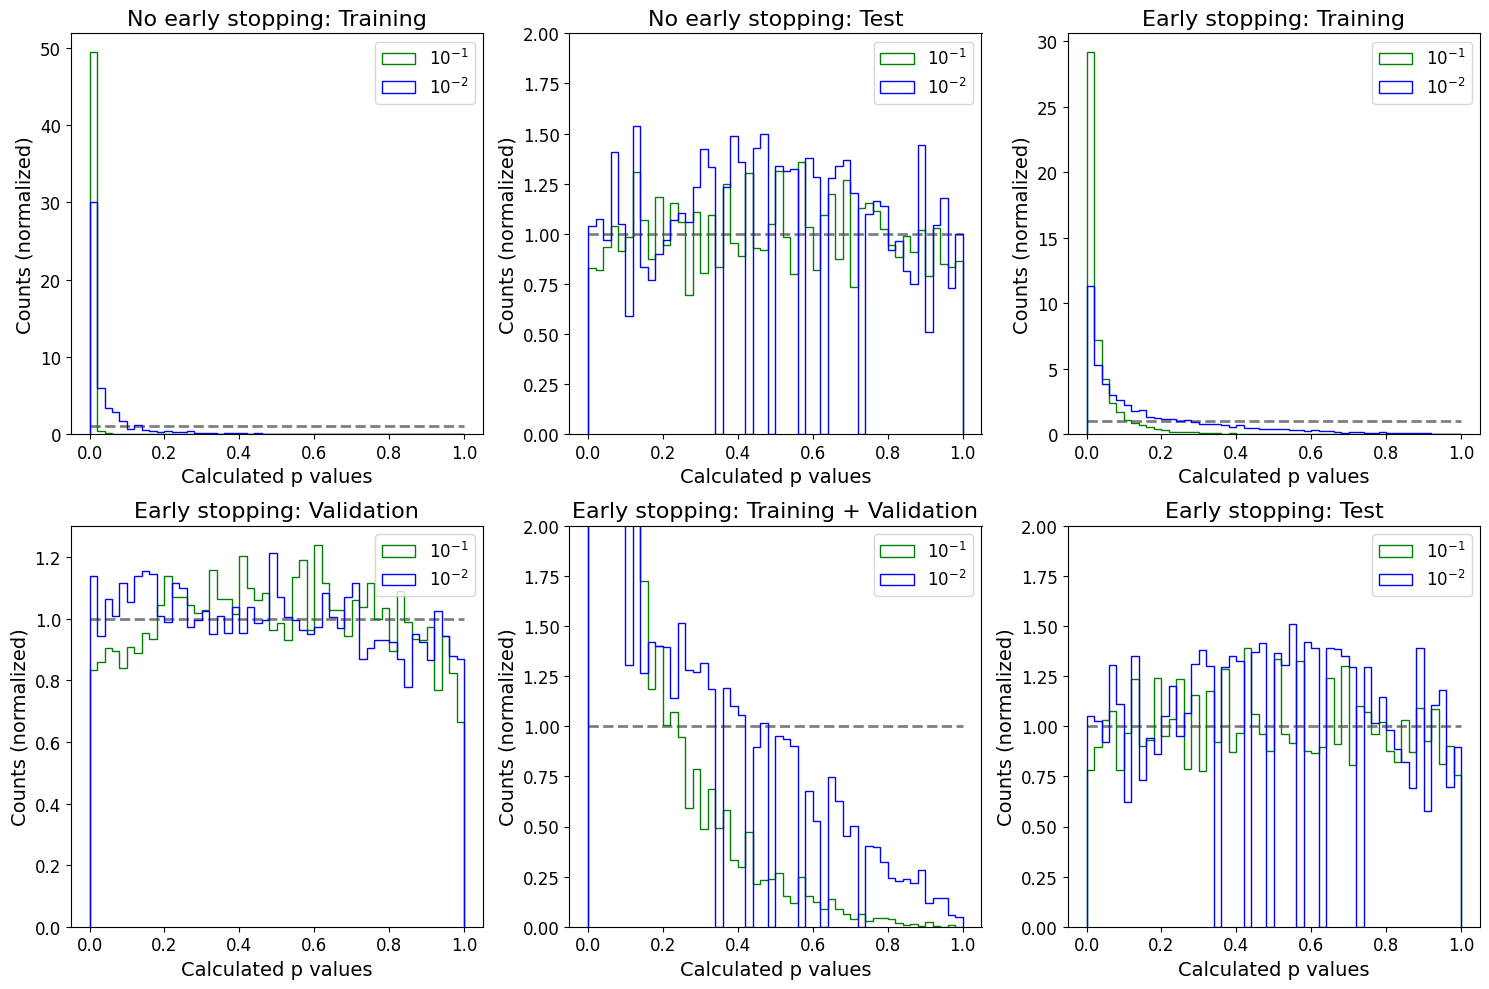

In [21]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=np.linspace(0,1,51)
bins_center = 0.5*(bins_plot[1:]+bins_plot[:-1])

p_earlystopping_train = np.load(directory+"p_values_earlystopping_train.npy",allow_pickle=True)
p_earlystopping_test = np.load(directory+"p_values_earlystopping_test.npy",allow_pickle=True)
p_earlystopping_splittrain = np.load(directory+"p_values_earlystopping_splittrain.npy",allow_pickle=True)
p_earlystopping_splitval = np.load(directory+"p_values_earlystopping_splitval.npy",allow_pickle=True)
p_noearlystopping_train = np.load(directory+"p_values_noearlystopping_train.npy",allow_pickle=True)
p_noearlystopping_test = np.load(directory+"p_values_noearlystopping_test.npy",allow_pickle=True)

for i in range(len(ax)):
    ax[i].set_xlabel("Calculated p values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")


plot_histogram(ax[0], p_noearlystopping_train, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("No early stopping: Training")
ax[0].legend(loc="upper right")

plot_histogram(ax[1], p_noearlystopping_test, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("No early stopping: Test")
ax[1].set_ylim(0,2)
ax[1].legend(loc="upper right")


plot_histogram(ax[2], p_earlystopping_splittrain, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[2].set_title("Early stopping: Training")
ax[2].legend(loc="upper right")

plot_histogram(ax[3], p_earlystopping_splitval, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[3].set_title("Early stopping: Validation")
#ax[3].set_ylim(0,2)
ax[3].legend(loc="upper right")

plot_histogram(ax[4], p_earlystopping_train, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[4].set_title("Early stopping: Training + Validation")
ax[4].set_ylim(0,2)
ax[4].legend(loc="upper right")

plot_histogram(ax[5], p_earlystopping_test, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[5].set_title("Early stopping: Test")
ax[5].set_ylim(0,2)
ax[5].legend(loc="upper right")

fig.tight_layout()
fig.savefig("plots/NN_histograms.pdf")

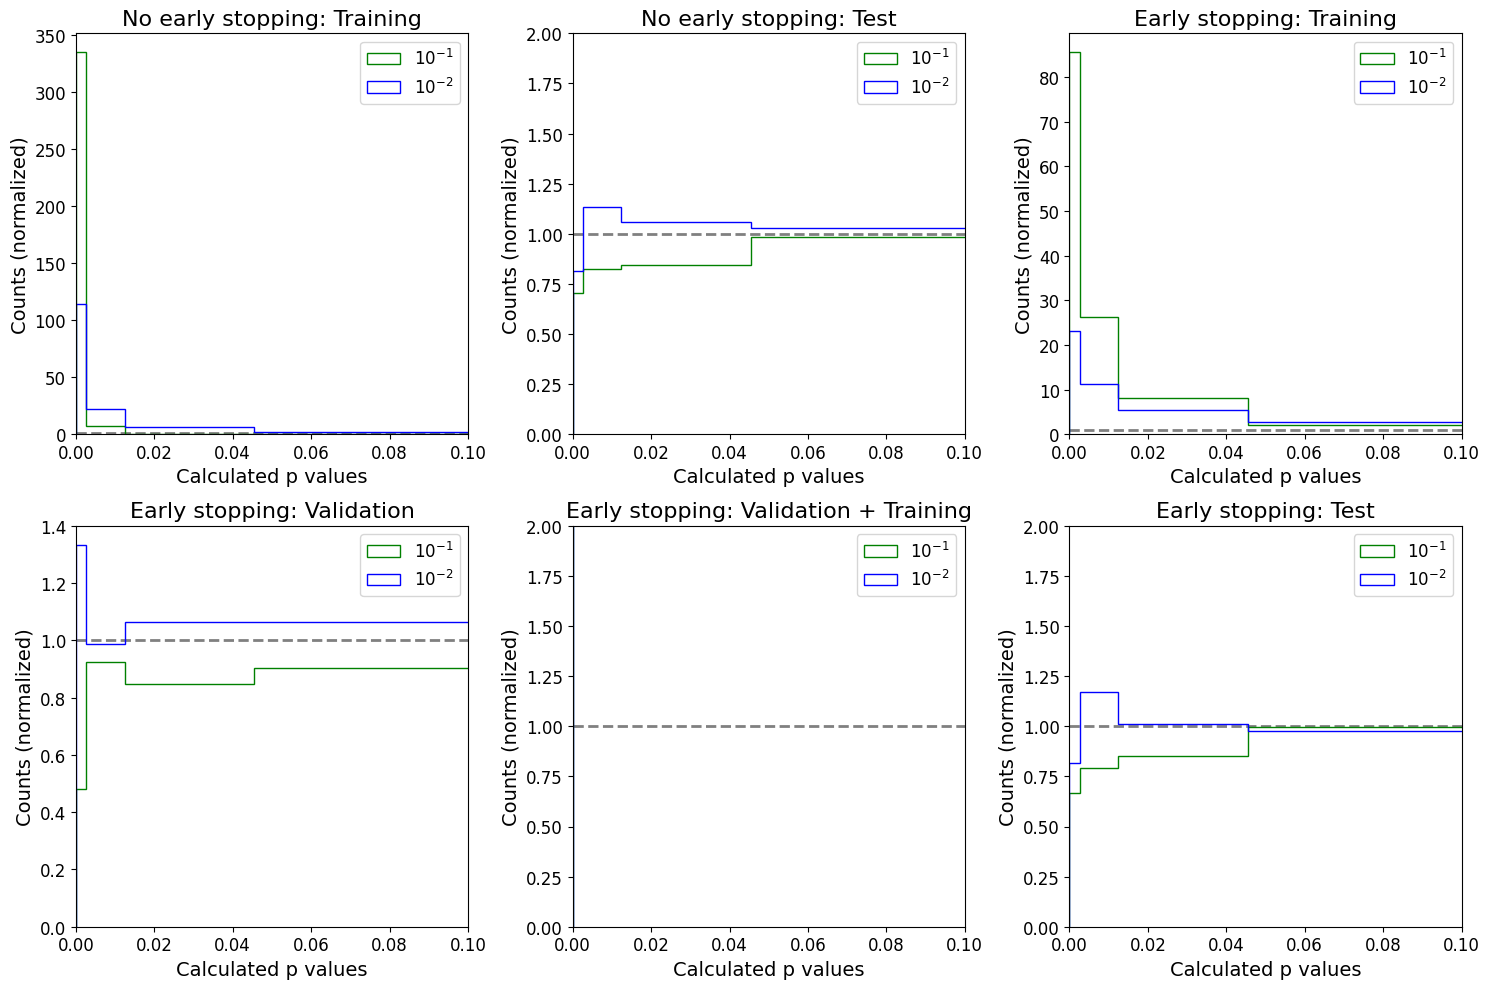

In [22]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]

p_earlystopping_train = np.load(directory+"p_values_earlystopping_train.npy",allow_pickle=True)
p_earlystopping_test = np.load(directory+"p_values_earlystopping_test.npy",allow_pickle=True)
p_earlystopping_splittrain = np.load(directory+"p_values_earlystopping_splittrain.npy",allow_pickle=True)
p_earlystopping_splitval = np.load(directory+"p_values_earlystopping_splitval.npy",allow_pickle=True)
p_noearlystopping_train = np.load(directory+"p_values_noearlystopping_train.npy",allow_pickle=True)
p_noearlystopping_test = np.load(directory+"p_values_noearlystopping_test.npy",allow_pickle=True)

for i in range(len(ax)):
    ax[i].set_xlabel("Calculated p values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")


plot_histogram(ax[0], p_noearlystopping_train, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("No early stopping: Training")
ax[0].legend(loc="upper right")

plot_histogram(ax[1], p_noearlystopping_test, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("No early stopping: Test")
ax[1].set_ylim(0,2)
ax[1].legend(loc="upper right")


plot_histogram(ax[2], p_earlystopping_splittrain, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[2].set_title("Early stopping: Training")
ax[2].legend(loc="upper right")

plot_histogram(ax[3], p_earlystopping_splitval, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[3].set_title("Early stopping: Validation")
#ax[3].set_ylim(0,2)
ax[3].legend(loc="upper right")

plot_histogram(ax[4], p_earlystopping_train, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[4].set_title("Early stopping: Validation + Training")
ax[4].set_ylim(0,2)
ax[4].legend(loc="upper right")

plot_histogram(ax[5], p_earlystopping_test, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[5].set_title("Early stopping: Test")
ax[5].set_ylim(0,2)
ax[5].legend(loc="upper right")


for i in range(len(ax)):
    ax[i].set_xlim(0,0.1)

fig.tight_layout()
fig.savefig("plots/NN_histograms_sigmas.pdf")

FileNotFoundError: [Errno 2] No such file or directory: '/hpcwork/zu992399/look_elsewhere/NN_test/NN_test_kfoldscorrected/p_values_earlystopping_train.npy'

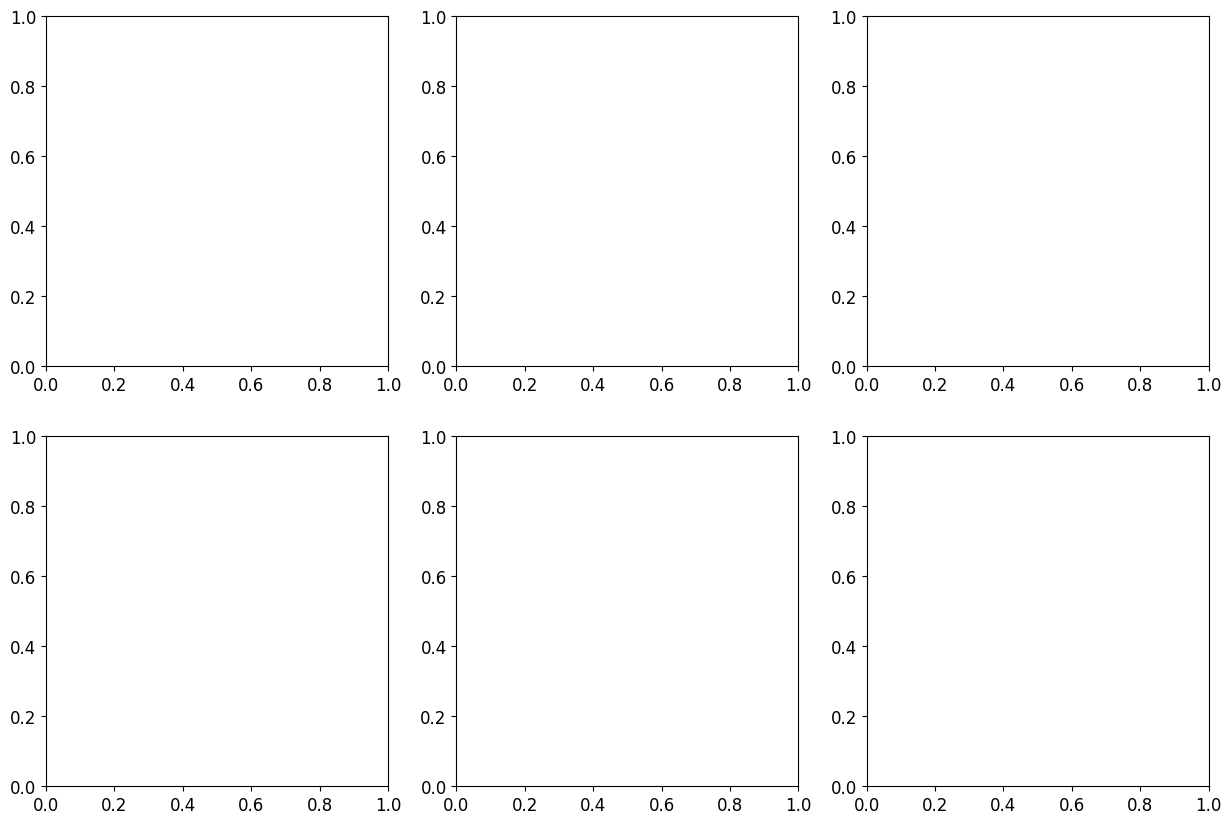

In [7]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

p_earlystopping_train = np.load(directory+"p_values_earlystopping_train.npy",allow_pickle=True)
p_earlystopping_test = np.load(directory+"p_values_earlystopping_test.npy",allow_pickle=True)
p_earlystopping_splittrain = np.load(directory+"p_values_earlystopping_splittrain.npy",allow_pickle=True)
p_earlystopping_splitval = np.load(directory+"p_values_earlystopping_splitval.npy",allow_pickle=True)
p_noearlystopping_train = np.load(directory+"p_values_noearlystopping_train.npy",allow_pickle=True)
p_noearlystopping_test = np.load(directory+"p_values_noearlystopping_test.npy",allow_pickle=True)


for i in range(len(ax)):
    ax[i].set_xlabel("Empirical p values")
    ax[i].set_ylabel("Calculated p values")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].plot([1e-5, 1], [1e-5, 1], color="grey", linestyle="dashed")


plot_array(ax[0], p_noearlystopping_train)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("No early stopping: Training")
ax[0].legend(loc="upper left")

plot_array(ax[1], p_noearlystopping_test)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("No early stopping: Test")
ax[1].set_ylim(0,2)
ax[1].legend(loc="upper left")


plot_array(ax[2], p_earlystopping_splittrain)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[2].set_title("Early stopping: Training")
ax[2].legend(loc="upper left")

plot_array(ax[3], p_earlystopping_splitval)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[3].set_title("Early stopping: Validation")
#ax[3].set_ylim(0,2)
ax[3].legend(loc="upper left")

plot_array(ax[4], p_earlystopping_train)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[4].set_title("Early stopping: Training + Validation")
ax[4].legend(loc="upper left")

plot_array(ax[5], p_earlystopping_test)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[5].set_title("Early stopping: Test")
ax[5].legend(loc="upper left")

fig.tight_layout()
fig.savefig("plots/NN_cumulative.pdf")

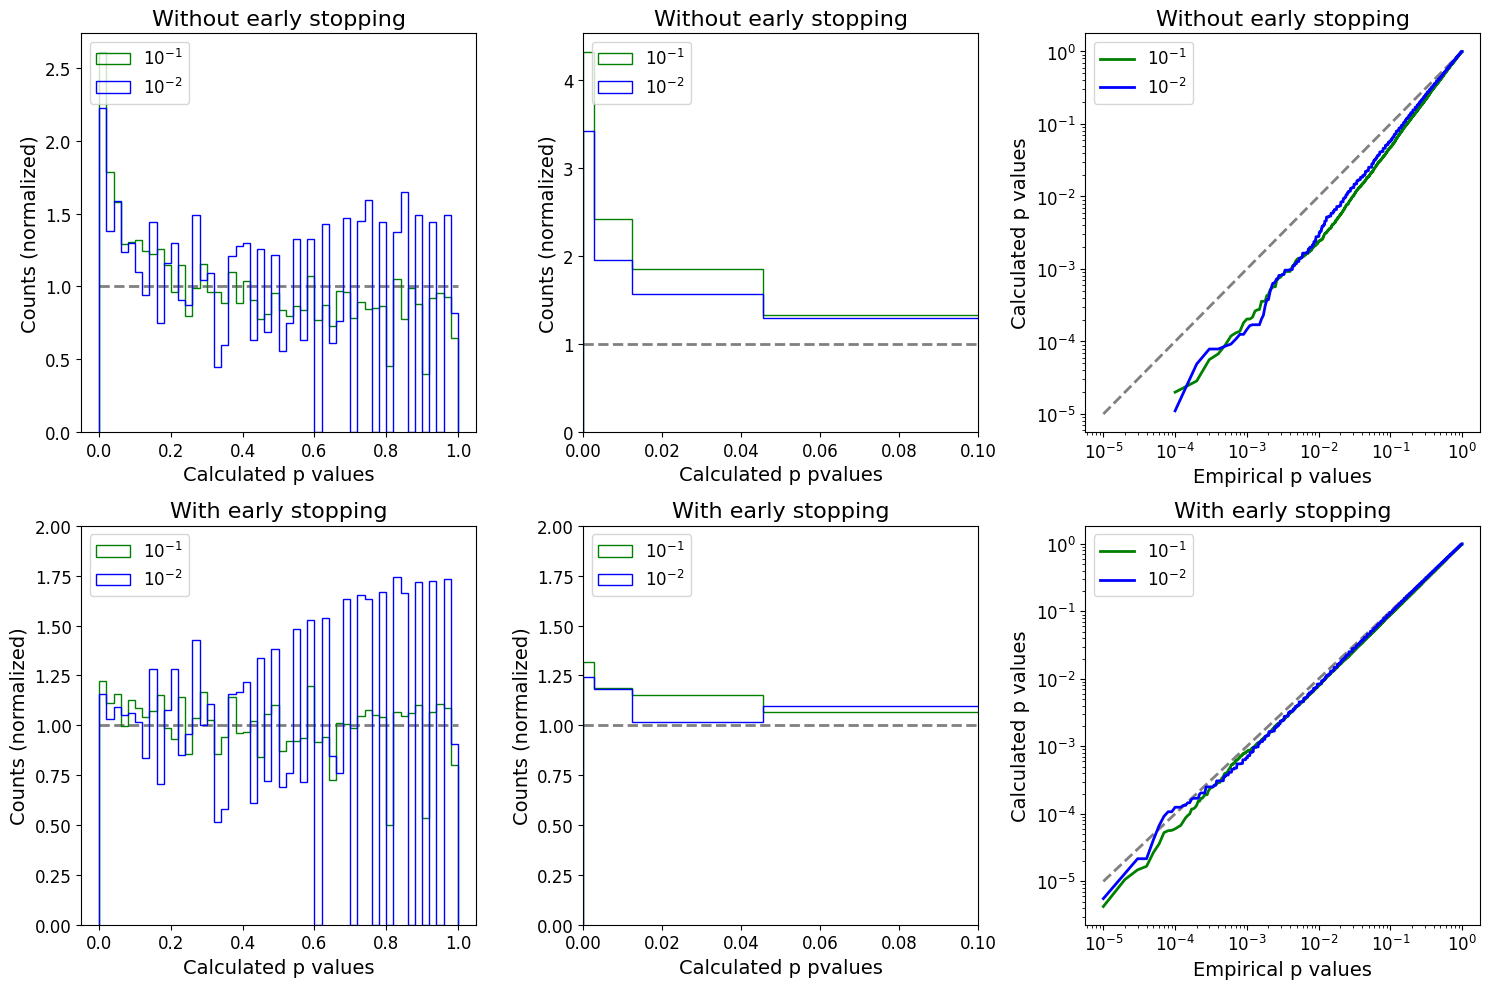

In [8]:
p_early = np.load(directory+"p_values_kfolds_earlystopping_restore.npy", allow_pickle=True)
p_noearly = np.load(directory+"p_values_kfolds_noearlystopping.npy", allow_pickle=True)

fig, ax = plt.subplots(2,3, figsize=(15,10))
bins_plot=np.linspace(0,1,51)

for i in range(2):
    ax[i,0].set_xlabel("Calculated p values")
    ax[i,0].set_ylabel("Counts (normalized)")
    ax[i,0].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,1].set_xlabel("Calculated p pvalues")
    ax[i,1].set_ylabel("Counts (normalized)")
    ax[i,1].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,2].set_xlabel("Empirical p values")
    ax[i,2].set_ylabel("Calculated p values")
    ax[i,2].set_xscale("log")
    ax[i,2].set_yscale("log")
    ax[i,2].plot([1e-5, 1], [1e-5, 1], color="grey", linestyle="dashed")


plot_histogram(ax[0,0], p_noearly, bins_plot)
ax[0,0].set_title("Without early stopping")
ax[0,0].legend(loc="upper left")
#ax[0,0].set_ylim(0,2)


plot_histogram(ax[1,0], p_early, bins_plot)
ax[1,0].set_title("With early stopping")
ax[1,0].legend(loc="upper left")
ax[1,0].set_ylim(0,2)

bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]
plot_histogram(ax[0,1], p_noearly, bins_plot)
ax[0,1].set_title("Without early stopping")
ax[0,1].legend(loc="upper left")
ax[0,1].set_xlim(0,0.1)
#ax[0,1].set_ylim(0,2)


plot_histogram(ax[1,1], p_early, bins_plot)
ax[1,1].set_title("With early stopping")
ax[1,1].legend(loc="upper left")
ax[1,1].set_xlim(0,0.1)
ax[1,1].set_ylim(0,2)


plot_array(ax[0,2], p_noearly)
ax[0,2].set_title("Without early stopping")
ax[0,2].legend(loc="upper left")

plot_array(ax[1,2], p_early)
ax[1,2].set_title("With early stopping")
ax[1,2].legend(loc="upper left")

fig.tight_layout()
fig.savefig("plots/NN_kfolds.pdf")